In [93]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [21]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [118]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 
    'motorcycle', 'airplane', 'bus', 'train', 'truck', 
    'boat', 'traffic light', 'fire hydrant', 'N/A', 
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 
    'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 
    'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 
    'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 
    'snowboard', 'sports ball', 'kite', 'baseball bat', 
    'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 
    'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 
    'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 
    'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 
    'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 
    'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase', 
    'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

colors = [[np.random.randint(0, 255) for _ in range(3)] for _ in COCO_INSTANCE_CATEGORY_NAMES]      

In [109]:
len(COCO_INSTANCE_CATEGORY_NAMES)

91

In [119]:
def predict(model, img_path, threshold):
    img = Image.open(img_path)
    transform = transforms.Compose([transforms.ToTensor()])
    img = transform(img)
    
    pred = model([img])
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1], i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return pred_boxes, pred_class

def predict_show(img_path, threshold=0.5, rect_th=3, text_size=0.5, text_th=3):
    boxes, pred_class = predict(model, img_path, threshold)
    print(f'Total objects: {len(boxes)}')
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(boxes)):
        plot_one_box(boxes[i][0], img, colors[COCO_INSTANCE_CATEGORY_NAMES.index(pred_class[i])], label=pred_class[i])
        
    plt.figure(figsize=(20, 30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

def plot_one_box(x, im, color=None, label=None, line_thickness=3): 
    # Plots one bounding box on image 'im' using OpenCV 
    tl = line_thickness or round(0.002 * (im.shape[0] + im.shape[1]) / 2) + 1  # line/      +++font thickness 
    color = color or [np.random.randint(0, 255) for _ in range(3)] 
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3])) 
    cv2.rectangle(im, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA) 
    if label: 
        tf = max(tl - 1, 1)  # font thickness 
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0] 
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3 
        cv2.rectangle(im, c1, c2, color, -1, cv2.LINE_AA)  # filled 
        cv2.putText(im, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA) 

Total objects: 100


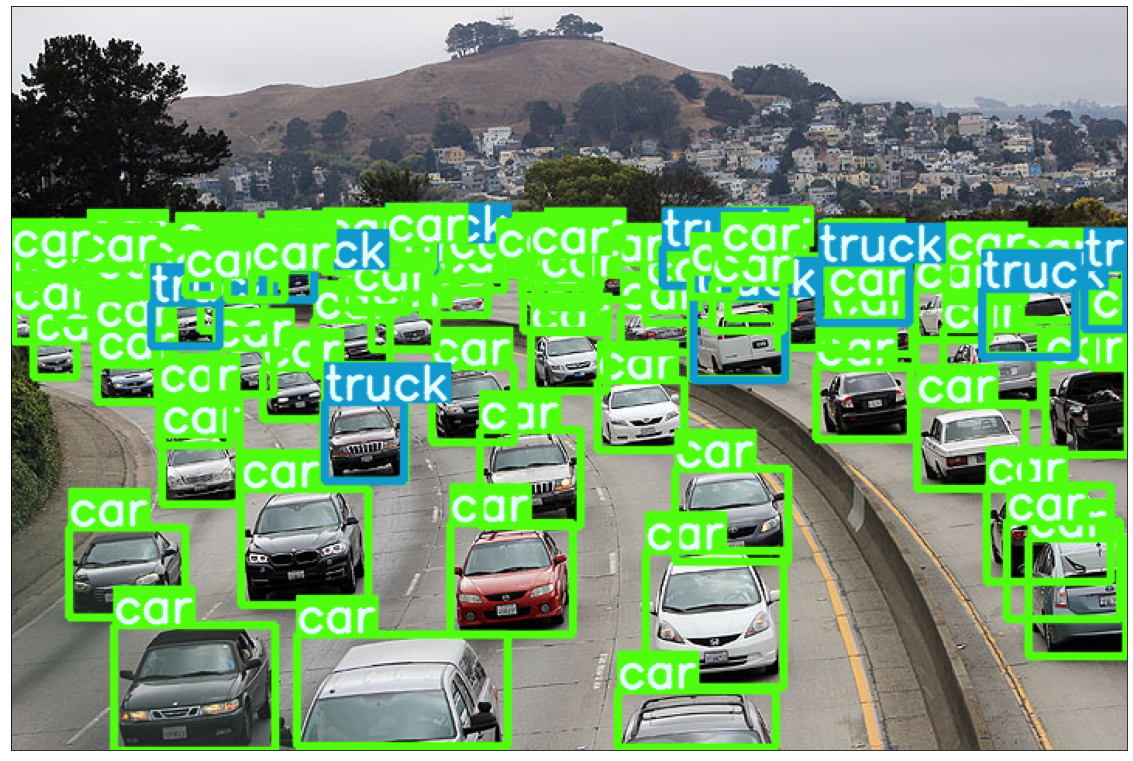

In [120]:
predict_show('image1.jpg', threshold=0.1)